### Character Level Bigram Language Model (step by step)

**Reading dataset**

In [1]:
words = open('names.txt').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

**Encoding/decoding**

In [13]:
chs = sorted(list(set('.' + ''.join(words))))
i_to_s = {i:s for i, s in enumerate(chs)}
s_to_i = {s:i for i, s in i_to_s.items()}

In [14]:
vocab_size = len(chs)
vocab_size

27

**Training bigram language model**

In [15]:
import torch

In [20]:
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int64)

for word in words:
    word = '.' + word + '.'
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        N[ix1, ix2] += 1

**Visualizing bigram counts**

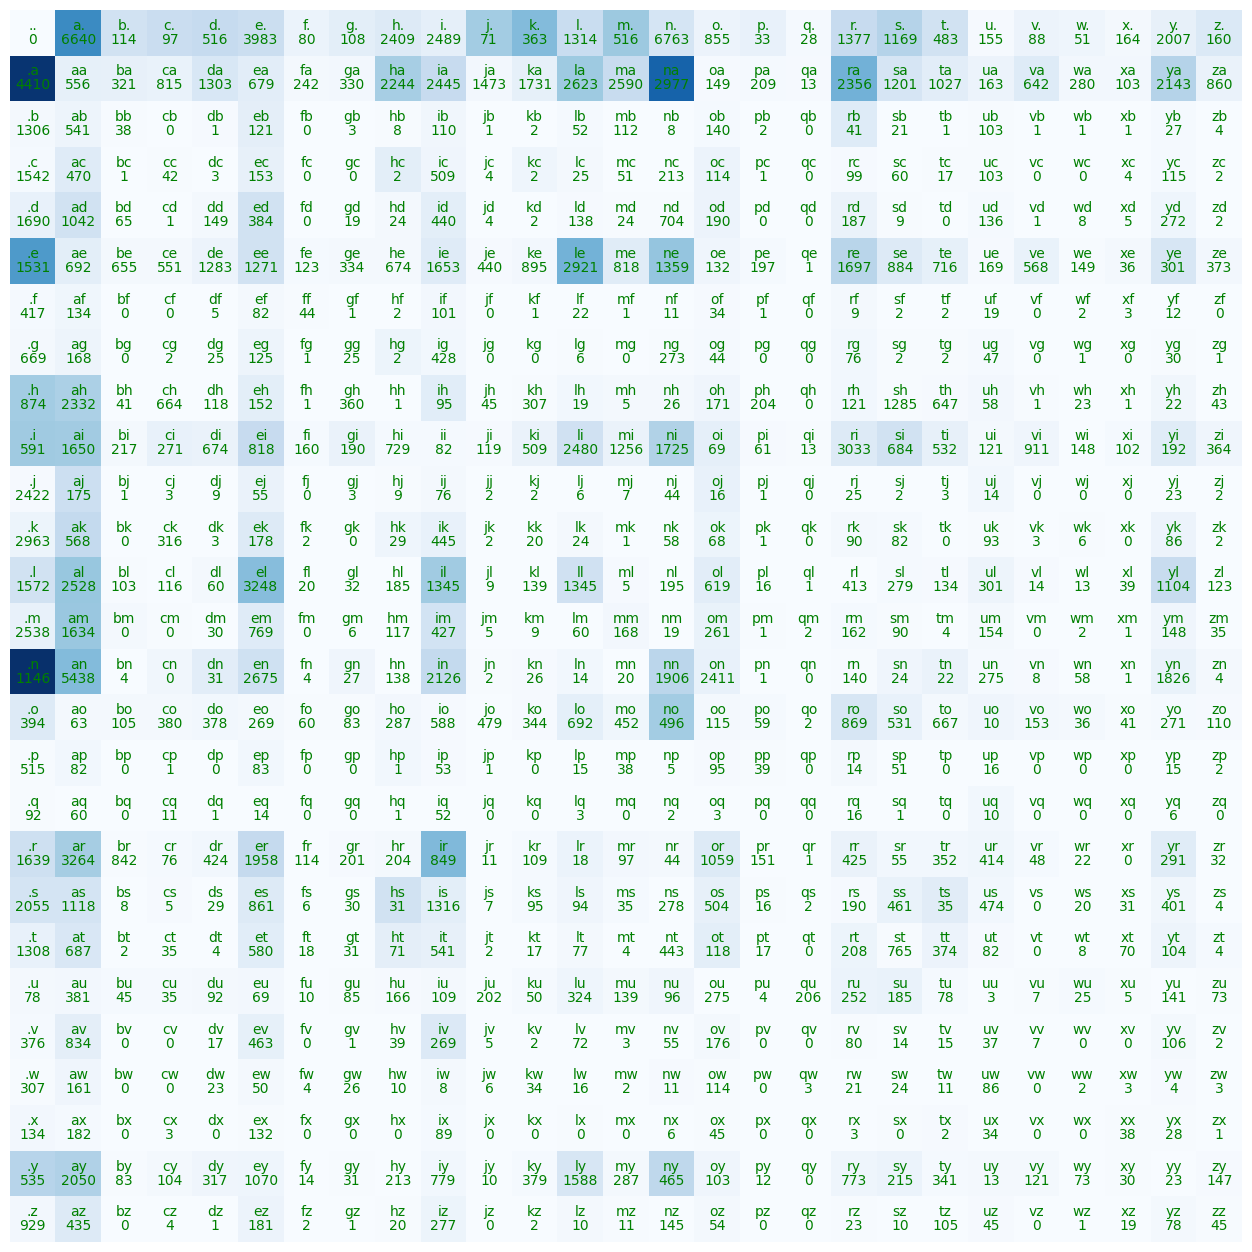

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        text = i_to_s[i] + i_to_s[j]
        plt.text(i, j, text, va='bottom', ha='center', color='green')
        plt.text(i, j, N[i, j].item(), va='top', ha='center', color='green')
plt.axis('off');

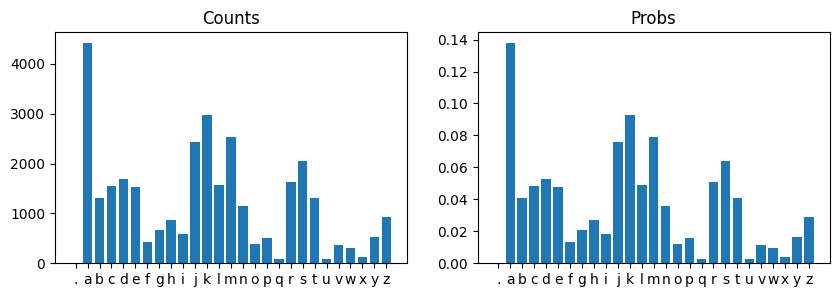

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.bar(list(chs), N[0])
plt.title('Counts')
plt.subplot(122)
plt.bar(list(chs), N[0]/N[0].sum())
plt.title('Probs');

**From counts to probs**

In [126]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [127]:
P[0].sum().item()

1.0

**understanding `torch.multinomial`**

In [128]:
g = torch.Generator().manual_seed(42)
n = 1000
samples = torch.multinomial(P[0], num_samples=n, replacement=True, generator=g)
for i in samples[:30]:
    print(i_to_s[i.item()], end=' ')
print()

a a a a k j y v a a b h s s h l a m l j a m e e a a v b d a 


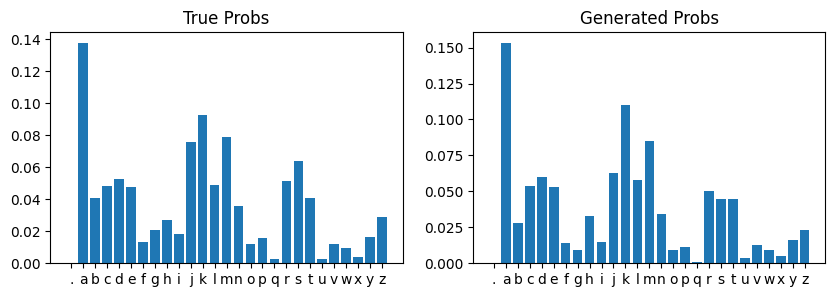

In [129]:
from collections import Counter

d = dict.fromkeys(chs, 0)
d.update(Counter([i_to_s[i.item()] for i in samples]))

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.bar(list(chs), (N+1)[0]/(N+1)[0].sum())
plt.title('True Probs')
plt.subplot(122)
plt.bar(d.keys(), [val / n for val in d.values()]);
plt.title('Generated Probs');

**sampling from the model**

In [130]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        s = i_to_s[ix]
        print(s, end='')
    print()

ya
syahavilin
dleekahmangonya
tryahe
chen
ena
da
amiiae
a
keles


**testing with uniform distribution**

In [131]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    ix = 0
    while True:
        p = torch.ones(vocab_size) / vocab_size
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        s = i_to_s[ix]
        print(s, end='')
    print()

yeosyohlvfbgqqdlxgktsmzmgwnyb
tryvwdxchwndenbedlppmjiaeqybkejmszqsqgtoyzjovtkimpupooznnyzujfosjvslrumxtonaclpgcyaqxknvzioiuqrtensqvgsumjqwqeioionyyrmnyctrjzdwtyazxdbpnftaauzyskakoth
eyumwlni
zripawaejtxpoxkelygylxsqfdcnidebwfmbiaaewbtorpaclulyaixbxsmpsvqccgkmbr
bcqfmfdvushlqqaspiaycg
tnaj
qtjaharpzjdhomfrlwzhwsuecdxlxjaffcgqinsfahigwkychfpnucnlsknkkdimfqcytgmpzildaanaonxdlcihv
sshzdgzlgvxvtcgumtrxpsbfvvaomwnmandgevfbluadt
rulci
cyjipcsvpwoxarvcbzbe


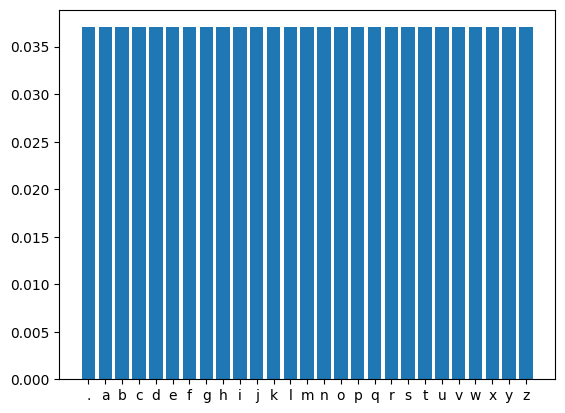

In [132]:
plt.bar(list(chs), p);

**calculating the loss**

In [144]:
log_loss = 0
n = 0
for word in words:
    word = '.' + word + '.'
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        prob = P[ix1, ix2]
        logit = prob.log()
        log_loss += logit
        n += 1

nll = -log_loss / n
print(nll)

tensor(2.4544)


In [151]:
log_likelihood = 0.
n = 0

for word in words:
    word = '.' + word + '.'
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood
print(f'{log_likelihood=}')
print(f'{nll/n=}')

log_likelihood=tensor(-559951.5625)
nll/n=tensor(2.4544)


If all the probabilities are 1, then the log_likelihood is 0. If all the probabilities are close to 0, then the log_likelihood grows more and more negative.

Loss function has the semantics that low is good. So we need to invert log_likelihood.

In [161]:
log_likelihood = 0.
n = 0

for word in ['andrejq']:
    word = '.' + word + '.'
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood
print(f'{log_likelihood=}')
print(f'{nll/n=}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelihood=tensor(-27.8672)
nll/n=tensor(3.4834)


## Neural Network Approach

**create training set of bigrams**

In [ ]:
xs, ys = [], []

for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        # print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .
. i
i s
s a
a b
b e
e l
l l
l a
a .
. s
s o
o p
p h
h i
i a
a .
. c
c h
h a
a r
r l
l o
o t
t t
t e
e .
. m
m i
i a
a .
. a
a m
m e
e l
l i
i a
a .
. h
h a
a r
r p
p e
e r
r .
. e
e v
v e
e l
l y
y n
n .
. a
a b
b i
i g
g a
a i
i l
l .
. e
e m
m i
i l
l y
y .
. e
e l
l i
i z
z a
a b
b e
e t
t h
h .
. m
m i
i l
l a
a .
. e
e l
l l
l a
a .
. a
a v
v e
e r
r y
y .
. s
s o
o f
f i
i a
a .
. c
c a
a m
m i
i l
l a
a .
. a
a r
r i
i a
a .
. s
s c
c a
a r
r l
l e
e t
t t
t .
. v
v i
i c
c t
t o
o r
r i
i a
a .
. m
m a
a d
d i
i s
s o
o n
n .
. l
l u
u n
n a
a .
. g
g r
r a
a c
c e
e .
. c
c h
h l
l o
o e
e .
. p
p e
e n
n e
e l
l o
o p
p e
e .
. l
l a
a y
y l
l a
a .
. r
r i
i l
l e
e y
y .
. z
z o
o e
e y
y .
. n
n o
o r
r a
a .
. l
l i
i l
l y
y .
. e
e l
l e
e a
a n
n o
o r
r .
. h
h a
a n
n n
n a
a h
h .
. l
l i
i l
l l
l i
i a
a n
n .
. a
a d
d d
d i
i s
s o
o n
n .
. a
a u
u b
b r
r e
e y
y .
. e
e l
l l
l i
i e
e .
. s
s t


In [167]:
xs

tensor([ 0,  5, 13, 13,  1])

In [168]:
ys

tensor([ 5, 13, 13,  1,  0])

In [258]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=vocab_size).float()
xenc.shape

torch.Size([228146, 27])

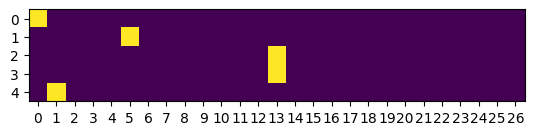

In [180]:
plt.imshow(xenc)
plt.yticks(range(len(xenc)))
plt.xticks(range(vocab_size));

**randomly initialize weights**

In [259]:
W = torch.randn((vocab_size, vocab_size), requires_grad=True)

**training the model**

In [304]:
for _ in range(1000):
    out = xenc @ W
    counts = out.exp()
    logits = counts / counts.sum(1, keepdim=True)
    nll = -logits[range(len(ys)), ys].log().mean()
    W.grad = None
    nll.backward()
    W.data -= 0.9 * W.grad

print(f'{nll=}')

nll=tensor(2.4966, grad_fn=<NegBackward0>)


**sampling from the model**

In [305]:
g = torch.Generator().manual_seed(42)
for _ in range(5):
    ix = 0
    preds = []
    while True:
        enc = F.one_hot(torch.tensor(ix), vocab_size).float()
        logits = torch.softmax(enc @ W, dim=0)
        ix = torch.multinomial(logits, 1, replacement=True, generator=g).item()
        if ix == 0:
            break
        preds.append(i_to_s[ix])
    print(''.join(preds))

ya
syahavilin
dleekahmangonya
tryahe
chen


Must to learn:

- Baye's Theorem
- Conditional Probability
- Joint Distribution
- Dummy Variable Trap
